In [15]:
%cd /content/drive/MyDrive/Colab\ Notebooks/StyleTransfer/Deeplearning_project

/content/drive/MyDrive/Colab Notebooks/StyleTransfer/Deeplearning_project


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import save_model, load_model
import cv2
from tqdm import tqdm

In [ ]:
CONTENT_PATH = './content' # content image 경로
STYLE_PATH = './style' # style image 경로
BATCH_SIZE = 10 # 배치사이즈

In [ ]:
content_image_generator = ImageDataGenerator(rescale=1./255) # image scaling
content_data_generator = content_image_generator.flow_from_directory(directory=CONTENT_PATH, batch_size=BATCH_SIZE, shuffle=True) # content image load
style_image_generator = ImageDataGenerator(rescale=1./255) # image scaling
style_data_generator = style_image_generator.flow_from_directory(directory=STYLE_PATH, batch_size=BATCH_SIZE, shuffle=True)# style image load

Found 10000 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.


In [3]:
def get_one_mixed_batch(): # 배치로 이미지 가져오기
    contentX, _ = next(content_data_generator)
    styleX, _ = next(style_data_generator)
    return contentX, styleX

In [4]:
CHECKPOINT_PATH = "./Weights" # weight path
def save_weights(model, epoch, path = CHECKPOINT_PATH): # save weight
    model.save_weights(path + '/weights{}.h5'.format(epoch))
    print('Saved weights for epoch {}'.format(epoch))

In [5]:
class AdaIN(Layer): # AdaIN layer
    def __init__(self, epsilon=1e-5, **kwargs):
        self.eps = epsilon
        super(AdaIN, self).__init__(**kwargs)

    def call(self, inputs):
        content, style, alpha = inputs

        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True) # content image의 평균과 분산
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True) # style image의 평균과 분산

        sigmaC = tf.sqrt(tf.add(varC, self.eps)) # content image의 표준편차
        sigmaS = tf.sqrt(tf.add(varS, self.eps)) # style image의 표준편차

        adain = (content - meanC) * sigmaS / sigmaC + meanS # AdaIN 구하기 (Content statistic에 Style statistic 입히기)
        return alpha * adain + (1 - alpha) * content # alpha값에 따른 Style transfer 비율

    def get_config(self):
        config = super().get_config().copy()
        return config

In [6]:
class ReflectionPadding2D(tf.keras.layers.Layer): # Reflection padding

    def __init__(self, padding, **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.paddings = ((0, 0), (padding, padding), (padding, padding), (0, 0))

    def call(self, x):
        return tf.pad(x, paddings=self.paddings, mode='REFLECT')

    def get_config(self):
        config = {'paddings': self.paddings}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
def build_vgg19(): # Encoder
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # feature extraction을 위한 VGG19 로드
    vgg.trainable = False # Transfer learning으로 사전 학습된 VGG19이므로 Non-training variable로 설정
    outputs = vgg.get_layer('block4_conv1').output # Conv layer에서 Conv4 layer를 output으로 사용
    model = tf.keras.Model([vgg.input], outputs, name='VGG_Encoder')
    return model
def build_vgg19_relus(vgg19): # Conv layer output extractor
    relus = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1'] # style loss를 구할 때 여러 층의 conv layer를 사용하므로
    features = [vgg19.get_layer(relu).output for relu in relus]# VGG19에서 위에서 정의한 layer의 output 추출
    vgg19_relus = Model(inputs=vgg19.input, outputs=features) 
    vgg19_relus.trainable = False # Non-training variable로 설정
    return vgg19_relus

In [8]:
def build_decoder(input_shape): # Decoder
    input = Input(shape = input_shape)
    x = input
    x = ReflectionPadding2D(padding=1)(x) # Border artifact를 피하기 위해 Reflection padding 사용 
    x = Conv2D(256, (3,3), activation='relu', padding='valid')(x)
    x = UpSampling2D((2,2))(x)

    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(256, (3,3), activation='relu', padding='valid')(x)
    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(256, (3,3), activation='relu', padding='valid')(x)
    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(256, (3,3), activation='relu', padding='valid')(x)
    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(128, (3,3), activation='relu', padding='valid')(x)
    x = UpSampling2D((2,2))(x)

    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(128, (3,3), activation='relu', padding='valid')(x)
    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
    x = UpSampling2D((2,2))(x)

    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
    x = ReflectionPadding2D(padding=1)(x)
    x = Conv2D(3, (3,3), padding='valid')(x)
    output = x
    return Model(inputs=[input],outputs=[output])

In [9]:
def build_model(encoder, decoder, input_shape): # Style transfer model
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')
    # 입력으로 content image, style image, alpha
    enc_content = encoder(content)
    enc_style = encoder(style)
    # Encoer에 content image와 style image를 Input으로 넣어 특징 추출
    adain = AdaIN()([enc_content, enc_style, alpha])
    # AdaIN layer에서 Style transfer
    out = decoder(adain)
    # Style transfer된 feature를 decoding하여 결과 이미지 생성
    return Model(inputs=[content, style, alpha], outputs=[out, adain]) # 결과 이미지와 AdaIN feature 반환

In [10]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=10):
    def loss(y_true, y_pred):
        # y_true = [content, style] 
        out, adain = y_pred[0], y_pred[1] # model의 output
        
        enc_out = encoder(out) # 결과 이미지를 다시 Encoding하여 특징 추출
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))
        # AdaIN feature와 결과 이미지가 Encoding 된 feature의 차이를 loss로 정의
        
        style = y_true[1]
        style_featues = vgg19_relus(style) # style 이미지를 Encoder에 넣어 특징 추출
        gen_features = vgg19_relus(out) # 결과 이미지를 Encoder에 넣어 특징 추출
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2]) # style 이미지의 평균과 분산
            meanG, varG = tf.nn.moments(enc_gen_feat, [1, 2]) # 결과 이미지의 평균과 분산

            sigmaS = tf.sqrt(varS + epsilon) # style 이미지의 표준편차
            sigmaG = tf.sqrt(varG + epsilon) # 결과 이미지의 표준편차

            l2_mean = tf.reduce_sum(tf.square(meanG - meanS)) # style 이미지의 평균과 결과 이미지의 평균이 같아지도록 loss 정의
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS)) # style 이미지의 표준편차와 결과 이미지의 표준편차가 같아지도록 loss 정의

            style_layer_loss.append(l2_mean + l2_sigma) # 평균 loss와 표준편차 loss의 합을 style loss로 정의

        style_loss = tf.reduce_sum(style_layer_loss) # 각 layer의 style loss의 합이 전체 style loss

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss # style loss에 weight을 부여하여 style 효과를 더 줄 수 있도록 하기 위해
        total_loss = content_loss + weighted_style_loss # 전체 loss는 content loss와 style loss의 합
        return total_loss, content_loss, weighted_style_loss

    return loss

In [11]:
def train(model, loss, n_epochs=10):
    optimizer = Adam(lr=1e-4, decay=5e-5) # Optimizer로 Adam사용
    n_batches = len(style_data_generator)
    alpha = 1.0 # alpha 값은 1.0으로 학습 후 prediction에서 조정 가능
    for e in range(1, n_epochs + 1):
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        pbar = tqdm(total=n_batches, ncols=50)
        for i in range(n_batches):
            # 배치 사이즈로 이미지 가져오기
            content, style = get_one_mixed_batch()
            if content is None or style is None:
                break
            
            # Training
            with tf.GradientTape() as tape:
                prediction = model([content, style, alpha])
                loss_values = loss([content, style], prediction)
            grads = tape.gradient(loss_values[0], model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            pbar.update(1)
        save_weights(model,e) # Epoch마다 weight 저장

In [12]:
def get_image(img_path, resize=True, shape=(256,256)): # resize가 True면 이미지 사이즈 (256,256)으로 설정
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if resize:
        image = cv2.resize(image, shape)
    image = image.astype(np.float32)
    return image

In [ ]:
# Training
INPUT_SHAPE = (None, None, 3) # Input의 사이즈는 제한이 없다
EPOCHS = 10 # Epoch 크기
EPSILON = 1e-5 # 표준편차가 0이 되는 것을 방지하기 위해

vgg19 = build_vgg19()  # Encoder
decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
model = build_model(vgg19, decoder, INPUT_SHAPE) # Style transfer model

model.load_weights(CHECKPOINT_PATH+'/weights7.h5') # 저장해둔 weight을 가져와서 이어서 학습

vgg19_relus = build_vgg19_relus(vgg19) # Style loss를 구하기 위해 Conv layer값 추출
loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON) # loss 

train(model, loss, n_epochs=EPOCHS) # 학습

In [23]:
# Prediction
INPUT_SHAPE = (None, None, 3) # Input shape
vgg19 = build_vgg19()  # Encoder
decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
model = build_model(vgg19, decoder, INPUT_SHAPE) # build model
model.load_weights('./weights7.h5') # load weight
content_path = "./data/1.jpg" # content image
style_path = "./data/style.png" # style image
content = get_image(content_path, resize=False) # load content image
style = get_image(style_path, resize=False) # load style image
content = content / 255 # image scaling
style = style / 255 # image scaling
content = content[np.newaxis] # model의 Input shape이 4차원이므로 이미지에 1차원 추가
style = style[np.newaxis] # model의 Input shape이 4차원이므로 이미지에 1차원 추가
alpha = 1.0 # alpha (조절 가능)
pred =model([content,style,alpha])[0] # 결과 이미지

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


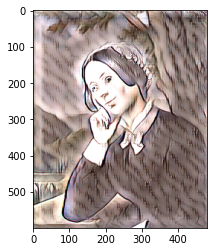

In [24]:
pred = tf.squeeze(pred) # model output shape이 4차원이므로 이미지를 출력하기 위해 차원 축소
plt.imshow(pred) # Show image